In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir('/content/drive/MyDrive/image captioning /Pytorch_lightning')

In [3]:
!ls 

data  inference_v1.ipynb  logs	       train_v1.ipynb
icap  inference_v2.ipynb  saved_model  train_v2.ipynb


In [4]:
!pip install pytorch-lightning

     |████████████████████████████████| 525 kB 5.3 MB/s 
     |████████████████████████████████| 132 kB 41.8 MB/s 
     |████████████████████████████████| 829 kB 31.5 MB/s 
     |████████████████████████████████| 332 kB 40.2 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 1.1 MB 39.4 MB/s 
     |████████████████████████████████| 160 kB 43.5 MB/s 
     |████████████████████████████████| 192 kB 46.6 MB/s 
     |████████████████████████████████| 271 kB 38.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=f08b4602a68f2f1c378924fe0105326df2edb9e7069f543ee238f3fd55ab44a9
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [5]:
import pytorch_lightning 

In [6]:
pytorch_lightning.__version__

'1.5.6'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from icap import data, models, task, utils

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from torchmetrics import Accuracy

In [8]:
!pwd

/content/drive/My Drive/image captioning /Pytorch_lightning


In [10]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 8
SPLIT_VAL = 0.2

EMBED_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 1

LRATE = 3e-5
MAX_EPOCHS = 10
NUM_GPU=1

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

root_dir = "data/flickr8k/images/"
caption_file = "data/flickr8k/captions.txt"

train_loader, trainset = data.flickr_dataloader(root_dir, caption_file, transform=train_transform, batch_size = BATCH_SIZE, 
                                                num_workers=NUM_WORKERS, shuffle=True, train=True)

valid_loader, validset = data.flickr_dataloader(root_dir, caption_file, transform=valid_transform, batch_size = BATCH_SIZE, 
                                                num_workers=NUM_WORKERS, shuffle=False, train=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
len(train_loader)

1012

In [13]:
# initialize model, loss etc
PAD_INDEX = trainset.vocab.stoi["<PAD>"]
VOCAB_SIZE = len(trainset.vocab)
print(f'VOCAB_SIZE : {VOCAB_SIZE}')

model = models.ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(model.parameters(), lr=LRATE)
trainer_task = task.ImageCaptionTask(model, optimizer, criterion, vocab_size=VOCAB_SIZE)

VOCAB_SIZE : 2994


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
PAD_INDEX

0

In [15]:
checkpoint_path = '/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model'
# DEFAULTS used by the Trainer
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path,
    filename = 'flickr8k_net_{epoch}',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

tensorboard_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/image captioning /Pytorch_lightning/logs/test')

trainer = pl.Trainer(max_epochs=MAX_EPOCHS, gpus=NUM_GPU, 
                     logger=tensorboard_logger, callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
trainer.fit(trainer_task, train_loader, valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ImageCaptionNet  | 26.1 M
1 | criterion | CrossEntropyLoss | 0     
2 | metric    | Accuracy         | 0     
-----------------------------------------------
2.6 M     Trainable params
23.5 M    Non-trainable params
26.1 M    Total params
104.381   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 27. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Epoch 0, global step 1011: val_loss reached 5.09753 (best 5.09753), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=0.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 2023: val_loss reached 4.64016 (best 4.64016), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 3035: val_loss reached 4.33574 (best 4.33574), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 4047: val_loss reached 4.05225 (best 4.05225), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=3.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 5059: val_loss reached 3.84943 (best 3.84943), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 6071: val_loss reached 3.69855 (best 3.69855), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 7083: val_loss reached 3.58532 (best 3.58532), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=6.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 8095: val_loss reached 3.49576 (best 3.49576), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=7.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 9107: val_loss reached 3.42287 (best 3.42287), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 10119: val_loss reached 3.36442 (best 3.36442), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=9.ckpt" as top 1


# Inference

In [42]:
best_model = models.ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(best_model.parameters(), lr=LRATE)
best_task = task.ImageCaptionTask(best_model, optimizer, criterion, vocab_size=VOCAB_SIZE)

In [43]:
saved_checkpoint_path = '/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=9.ckpt'
checkpoint = torch.load(saved_checkpoint_path, map_location=lambda storage, loc: storage)
best_task.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [51]:
# Renormalize the img 
img, text = validset[41]
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
mean = torch.tensor(IMG_MEAN, device=img.device, dtype=img.dtype).view(1, -1, 1, 1)
std = torch.tensor(IMG_STD, device=img.device, dtype=img.dtype).view(1, -1, 1, 1)
origin_image = img * std + mean

In [55]:
origin_image.shape

torch.Size([1, 3, 224, 224])

predicted    :  a dog is running in the grass .
ground truth :  large dog plays with two smaller dogs on grass .


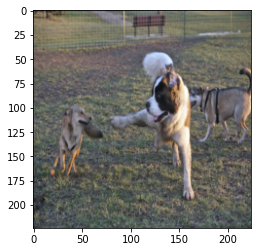

In [56]:
imtest = utils.ImageCaptionTest(best_model, validset.vocab)
imtest.show_result(origin_image, text)